In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clip
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )
from wotan import flatten
import pandas as pd
from OrionPY import Tools
import batman
from wotan import slide_clip


In [2]:
# Loading in the original data for obj_ids and rebinned data
hdu = Tools()
data = np.load('/data/jpr64/rebinned_data_test.npy', allow_pickle = True)





/home/jpr64/orion/Orion_main/OrionPY.py:71: RuntimeWarning: invalid value encountered in log10
  self.mag = -2.5*np.log10(self.flux)


In [3]:
# Putting data into lists
lc = [x for x in data]
obj_ids = [x for x in hdu.hdu[1].data['obj_id']]

idx = [i for i, j  in enumerate(lc) if not j.shape == (0,3)]

lc = [lc[i] for i in idx]
obj_ids = [obj_ids[i] for i in idx]




In [63]:
# Loading data of specific object

object_index = 2304

# object_id = '001173'
# object_index = obj_ids.index(object_id)

test = lc[object_index]
flux = test[:,1]
time = test[:,0]

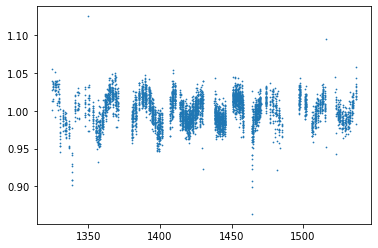

In [64]:
plt.scatter(time, flux/np.nanmean(flux), s= 0.5)

In [7]:
# Calculating magnitudes
def magnitude(lc):
    return -2.5* np.log10(lc[:,1]) + 20.2
def rms(magnitudes):
    return np.sqrt(np.mean(np.square(magnitudes - np.nanmean(magnitudes))))


magnitudes = [magnitude(x) for x in lc]
mean_mag = [np.nanmean(x) for x in magnitudes]
rms_mag = [rms(x) for x in magnitudes]

mean_mag = np.array(mean_mag)
rms_mag = np.array(rms_mag)




/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


IndexError: tuple index out of range

In [55]:
x = np.where(rms_mag < 10**(-1))[0]
x[1543]



1589

In [65]:
print(rms_mag[2304])

0.020477404888117837


In [66]:
# Make the injected transit.

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = time[0]  # time of inferior conjunction; first transit is X days after start
ma.per = 3.7 # orbital period
ma.rp = 0.1  # 1% dip planet radius (in units of stellar radii)
ma.a = 8.47 # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
ma.u = []  # limb darkening coefficients
ma.limb_dark = "uniform"  # limb darkening model
m = batman.TransitModel(ma, time)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

# Sigma clip the data and then run the TLS search
flux_transit = flux * synthetic_signal 


# clipped_flux = slide_clip(
#     time,
#     flux_transit,
#     window_length=1,
#     low=3,
#     high=2,
#     method='std',  # mad or std
#     center='median'  # median or mean
#     )


NameError: name 'clipped_flux' is not defined

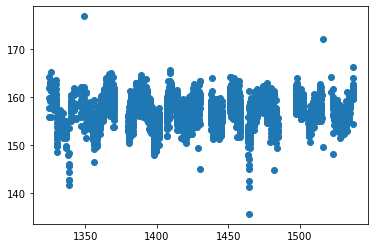

In [67]:
plt.scatter(time, flux_transit)
plt.scatter(time, clipped_flux)

In [68]:
output = pd.DataFrame()

for i in [7]: 
    w_length = i
    
    flatten_lc, trend_lc = flatten(
        time,                 # Array of time values
        flux_transit,                 # Array of flux values
        method='lowess',
        window_length = w_length ,    # The length of the filter window in units of ``time``
        return_trend=True,    # Return trend and flattened light curve
        )
    
    time_flatten, flatten_lc = cleaned_array(time, flatten_lc)
        
    flux_sigma_clipped = sigma_clip(flatten_lc, sigma_lower = float('inf'), sigma_upper= 3)
    
    model = transitleastsquares(time_flatten, flatten_lc)
    results = model.power(period_min = 1, period_max = 10, limb_dark = 'linear', u =[0], use_threads = 40, oversampling_factor=2)
    output = output.append(results, ignore_index = True)
    

/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4632 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:38<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 25 of 26 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [69]:
output['period']

0    7.960857
Name: period, dtype: float64

In [47]:
model = transitleastsquares(time, flux / np.nanmean(flux))
results = model.power(period_min = 1, period_max = 10, limb_dark = 'linear', u =[0], use_threads = 40, oversampling_factor=2)
output = output.append(results, ignore_index = True)

  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4632 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:37<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 104 of 142 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [48]:
output['per']

,FAP,SDE,SDE_raw,SR,T0,after_transit_count,before_transit_count,chi2,chi2_min,chi2red,...,power,power_raw,rp_rs,snr,snr_per_transit,snr_pink_per_transit,transit_count,transit_depths,transit_depths_uncertainties,transit_times
0,0.00024,8.863342,8.679790,"[0.9511372513325179, 0.9508909150211282, 0.950...",1324.514137,206.0,201.0,"[4596.813728734834, 4598.00457210098, 4600.087...",4372.200775,"[0.9932613934172069, 0.9935187061583794, 0.993...",...,"[-3.5496361117720627, -3.6028136890270837, -3....","[0.33043366466791263, 0.28834127714020863, 0.2...",0.191619,10.581146,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",107.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1324.5141370542742, 1326.5088121089298, 1328...."
1,0.00008,9.224776,7.595893,"[0.9603922678414579, 0.9631747427978532, 0.965...",1324.957301,131.0,135.0,"[4511.957002008066, 4498.922599417783, 4489.53...",4333.248618,"[0.9749258863457361, 0.9721094640055711, 0.970...",...,"[-1.7993330719135456, -1.2784840877869346, -0....","[1.8343784222328532, 2.239129433380763, 2.5319...",0.211837,9.708527,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",142.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1324.9573014386597, 1326.4539438185218, 1327...."


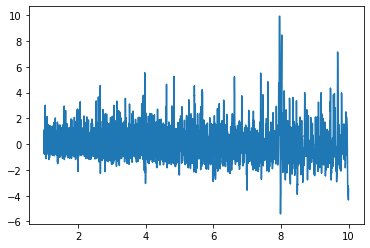

In [70]:
periods = output['periods'][0]
powers = output['power'][0]

plt.plot(periods, powers)

In [25]:
output = pd.DataFrame()

for i in np.linspace(1, 10, 12): 
    ma = batman.TransitParams()
    ma.t0 = time[0]  # time of inferior conjunction; first transit is X days after start
    ma.per = i # orbital period
    ma.rp = 0.1  # 1% dip planet radius (in units of stellar radii)
    ma.a = 8.47 # semi-major axis (in units of stellar radii)
    ma.inc = 90  # orbital inclination (in degrees)
    ma.ecc = 0  # eccentricity
    ma.w = 90  # longitude of periastron (in degrees)
    ma.u = []  # limb darkening coefficients
    ma.limb_dark = "uniform"  # limb darkening model
    m = batman.TransitModel(ma, time)  # initializes model
    synthetic_signal = m.light_curve(ma)  # calculates light curve

    # Sigma clip the data and then run the TLS search
    flux_transit = flux * synthetic_signal 


    
    
    
    
    w_length = 7
    
    flatten_lc, trend_lc = flatten(
        time,                 # Array of time values
        flux_transit,                 # Array of flux values
        method='lowess',
        window_length = w_length ,    # The length of the filter window in units of ``time``
        return_trend=True,    # Return trend and flattened light curve
        )
    
    time_flatten, flatten_lc = cleaned_array(time, flatten_lc)
        
# flux_sigma_clipped = sigma_clip(flatten_lc, sigma_lower = float('inf'), sigma_upper= 3)
    
    model = transitleastsquares(time_flatten, flatten_lc)
    results = model.power(period_min = 1, period_max = 10, limb_dark = 'linear', u =[0], use_threads = 40, oversampling_factor=2)
    output = output.append(results, ignore_index = True)
    

  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:40<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 195 of 212 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:41<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 106 of 116 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:41<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 72 of 81 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:41<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 52 of 61 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:39<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 47 of 50 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:41<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 38 of 41 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:41<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 33 of 36 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:38<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 27 of 31 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:38<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 25 of 28 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:38<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 22 of 25 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:40<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/stats.py:456: RuntimeWarning: divide by zero encountered in double_scalars
  snr_pink_per_transit[i] = (1 - mean_flux) / pinknoise
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 20 of 24 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/9042 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 36 durations
Searching 4618 data points, 9042 periods from 1.0 to 9.998 days
Using 40 of 64 CPU threads


100%|██████████| 9042/9042 periods | 00:41<00:00
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 15 of 21 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [26]:
output['period']

0     1.000035
1     1.818350
2     2.636301
3     3.455027
4     4.272722
5     5.091042
6     5.908523
7     6.726928
8     7.546316
9     8.363971
10    9.183434
11    9.997778
Name: period, dtype: float64

In [27]:
np.linspace(1,10,12)

array([ 1.        ,  1.81818182,  2.63636364,  3.45454545,  4.27272727,
        5.09090909,  5.90909091,  6.72727273,  7.54545455,  8.36363636,
        9.18181818, 10.        ])

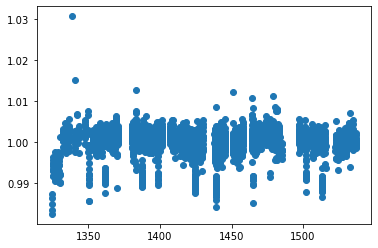

In [38]:
plt.scatter(time, flux_transit/np.nanmean(flux_transit))
# plt.scatter(time, flatten_lc)